In [56]:
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
import matplotlib.pyplot as plt

# download the mnist to the path '~/.keras/datasets/' if it is the first time to be called
# X shape (60,000 28x28), y shape (10,000, )
(x_train, _), (x_test, y_test) = mnist.load_data()

# data pre-processing
x_train = x_train.astype('float32') / 255.      # minmax_normalized
x_test = x_test.astype('float32') / 255.      # minmax_normalized
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [27]:
# in order to plot in a 2D figure
encoding_dim = 2

# this is our input placeholder
input_img = Input(shape=(784,))


In [42]:
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(2, activation='relu')(encoded)

# decoder layers
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

auto_encoder = Model(input_img, decoded)

In [60]:
# auto_encoder.summary()

In [46]:
encoder = Model(inputs=input_img, outputs=encoded)

In [47]:
auto_encoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [49]:
from keras.callbacks import TensorBoard

In [50]:
auto_encoder.fit(x_train, x_train, 
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
                )
                 

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s - loss: 0.4301 - val_loss: 0.2663
Epoch 2/20
60000/60000 [==============================] - 6s - loss: 0.2628 - val_loss: 0.2598
Epoch 3/20
60000/60000 [==============================] - 6s - loss: 0.2568 - val_loss: 0.2545
Epoch 4/20
60000/60000 [==============================] - 6s - loss: 0.2530 - val_loss: 0.2520
Epoch 5/20
60000/60000 [==============================] - 6s - loss: 0.2513 - val_loss: 0.2507
Epoch 6/20
60000/60000 [==============================] - 7s - loss: 0.2504 - val_loss: 0.2503
Epoch 7/20
60000/60000 [==============================] - 6s - loss: 0.2498 - val_loss: 0.2495
Epoch 8/20
60000/60000 [==============================] - 6s - loss: 0.2493 - val_loss: 0.2490
Epoch 9/20
60000/60000 [==============================] - 7s - loss: 0.2487 - val_loss: 0.2489
Epoch 10/20
60000/60000 [==============================] - 7s - loss: 0.2480 - val_loss: 0.2477

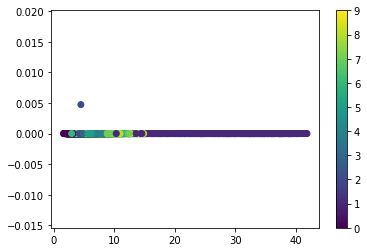

In [51]:
# plotting
encoded_imgs = encoder.predict(x_test)
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=y_test)
# plt.xlim, 0.010)
# plt.ylim(-0.005, 0.010)
plt.colorbar()
plt.show()

In [62]:
decoded_imgs = auto_encoder.predict(x_test)

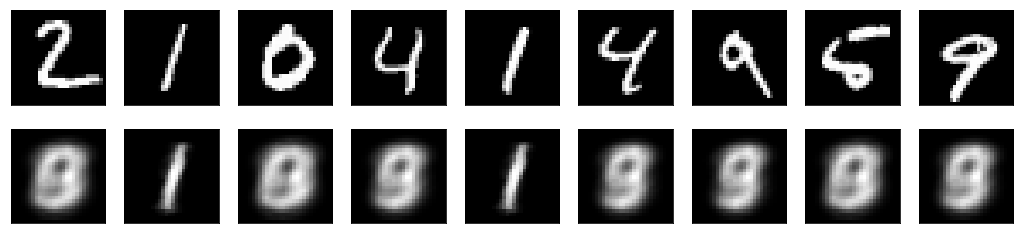

In [65]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Application to image denoising



In [70]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K


In [66]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

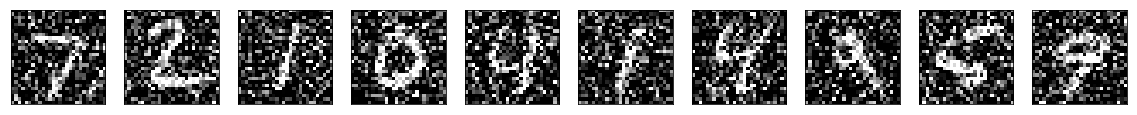

In [68]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [71]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [72]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 3584/60000 [>.............................] - ETA: 178s - loss: 0.4698

KeyboardInterrupt: 